### Try the network sampler

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_coloc.optimized_swap_proposal import MCMC
from bayes_coloc.exact_computations_for_poisson_model import pair_abundance_posterior


%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(10)

d = 2

# set parameters
area = 1
scale = 0.1
radius = 0.0
gamma = 5
alpha = 5# np.e**-20
beta = 5# np.e**-20
true_params = {'gamma': gamma, 'alpha': alpha, 'beta': beta,
    'scale': scale, 'radius': radius, 'area': area}

### Data generation 

n_gamma = np.random.poisson(lam=true_params['gamma']*area)
n_mu = np.random.poisson(lam=true_params['alpha']*area)
n_nu = np.random.poisson(lam=true_params['beta']*area)

# Sample points in space 
hatmu = np.random.random(size=(n_mu, d)) 
hatnu = np.random.random(size=(n_nu, d)) 
hatgamma_x = np.random.random(size=(n_gamma, d))
random_angles = 2*np.pi*np.random.random(size=n_gamma)
random_directions = np.vstack((np.cos(random_angles), np.sin(random_angles))).T
random_shift = random_directions * radius
hatgamma_y = hatgamma_x + np.random.normal(scale=scale, size=(n_gamma, d)) + random_shift

# Merge marginals
x = np.vstack((hatgamma_x, hatmu))
y = np.vstack((hatgamma_y, hatnu))

nx, ny = len(x), len(y)

# now shuffle the data
perm_x = np.random.permutation(nx)
perm_y = np.random.permutation(ny)
x = x[perm_x]
y = y[perm_y]

# COMPUTE (TRUE) MATCHING
unpermuted_matching_mat = np.zeros((nx, ny))
unpermuted_matching_mat[range(n_gamma), range(n_gamma)] = 1
matching_mat = unpermuted_matching_mat[:, perm_y]
matching_mat = matching_mat[perm_x, :]



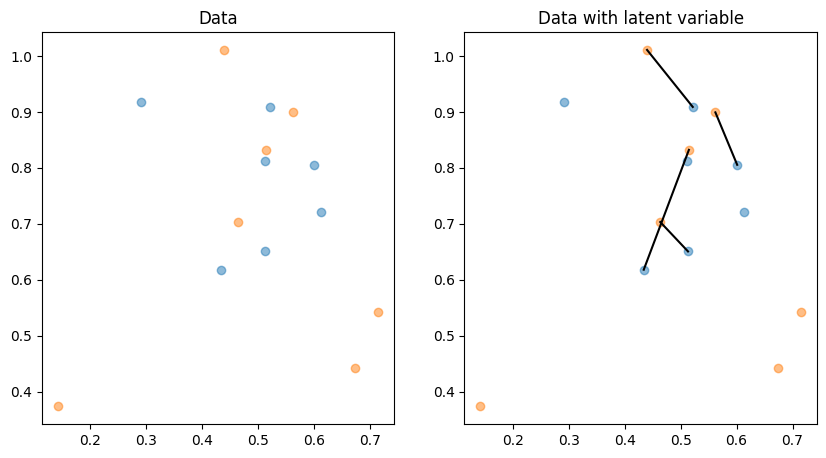

In [3]:

def plot_2d_plan(xs, xt, G, thr=0, ax=None, **kwargs):

    if ax is None:
        ax = plt.gca()
    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    if 'alpha' in kwargs:
        scalee = kwargs['alpha']
        del kwargs['alpha']
    else:
        scalee = 1
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                ax.plot(
                    [xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                    alpha=G[i, j] / mx * scalee, **kwargs
                )
fig, axis = plt.subplots(ncols=2, figsize=(10, 15))
for ax in axis:
    ax.scatter(x[:, 0], x[:, 1], alpha=0.5)
    ax.scatter(y[:, 0], y[:, 1], color="tab:orange", alpha=0.5)
    ax.set_aspect("equal")
plot_2d_plan(x, y, matching_mat, ax=axis[1])
axis[0].set_title("Data")
axis[1].set_title("Data with latent variable")
plt.show()

In [4]:
def l_xy(x, y, params):  
    """ Logarithm of joint intensity function"""
    # get parameters
    scale = params['scale']
    area = params['area']

    # compute log of joint intensity
    lxy = -np.sum((x-y)**2, axis=-1)/(2*scale**2) - np.log((2*np.pi*scale**2))
    lxy -= np.log(area)
    return lxy

def l_x(x, params):
    """ Logarithm of intensity function for x"""
    area = params['area']
    lx = np.zeros_like(x, dtype=float)
    lx = np.sum(lx, axis=-1)
    lx -= np.log(area)
    return lx

def l_y(y, params):
    """ Logarithm of intensity function for y"""
    area = params['area']
    ly = np.zeros_like(y, dtype=float)
    ly = np.sum(ly, axis=-1)
    ly -= np.log(area)
    return ly

In [5]:
# define proposal, prior and starting parameters
scale_interval = [0., 0.1]
radius_interval = [0, 0.1]

area = 1
hyper_theta = len(x)/2

def log_prior(params):
    """ Defines a log prior for the parameters of the model (up to a constant)"""
    
    alpha = params["alpha"]
    gamma = params['gamma']
    beta = params["beta"]
    radius = params['radius']
    scale = params['scale']
    return 0

def proposal(params):
    """ Defines a proposal for the parameters of the model """
    scale_temp = 0.0
    radius_temp = 0.0
    intensity_temp = 0
    
    scale = params['scale']
    radius = params['radius']
    alpha = params["alpha"]
    gamma = params['gamma']
    beta = params["beta"]
    
    # new proposal for the scale
    scale_new = scale + np.random.normal(scale=scale_temp)
    new_radius = radius + np.random.normal(scale=radius_temp)
    
    # new proposal for the intensities
    alpha_new = alpha + np.random.normal(scale=intensity_temp)
    beta_new = beta + np.random.normal(scale=intensity_temp)
    gamma_new = gamma + np.random.normal(scale=intensity_temp)
    
    return {"alpha": alpha_new, "beta": beta_new, "gamma": gamma_new, "scale": scale_new, "radius": new_radius, "area": area}

# start_params = {"alpha": hyper_theta, "beta": hyper_theta, "gamma": hyper_theta,
#                 "scale": 0.05, "radius": 0.05, "area": area}
start_params = true_params.copy()

swap_params = start_params.copy()



In [6]:
np.random.seed(0)
chain = MCMC(x, y, l_xy, l_x, l_y, start_params, swap_params, log_prior, proposal)
chain.latent_state.update_intensities(100, 100, 100)
chain.latent_state.update_intensities(alpha, beta, gamma)

In [7]:
chain.run(n_samples=3000, burn_in=0)
# chain.run(n_samples=10, burn_in=0)
print(len(chain.param_trajectory))

Burn-in period: 0it [00:00, ?it/s]
Sampling:   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: 100%|██████████| 3000/3000 [00:28<00:00, 105.23it/s]

3002


In [8]:
log_probs_fast = chain.latent_state.log_prob_marginal()
log_probs_slow = chain.latent_state.log_prob_marginal_slow() 
# print diff
print("log_probs_slow", log_probs_slow)
print("logL_probs_fast", log_probs_fast)
print("diff", log_probs_slow - log_probs_fast)


log_probs_slow [ 2.5873616  -6.32932427  0.50371718 -0.07874388  1.03081865  1.54000837
  2.47231062  0.95182912  1.97181719  1.14983088  0.76860344]
logL_probs_fast [ 2.5873616  -6.32932427  0.50371718 -0.07874388  1.03081865  1.54000837
  2.47231062  0.95182912  1.97181719  1.14983088  0.76860344]
diff [ 4.44089210e-16 -1.77635684e-14  1.11022302e-16  4.99600361e-16
  2.22044605e-16  0.00000000e+00 -1.73194792e-14  1.11022302e-16
  2.22044605e-16  0.00000000e+00  0.00000000e+00]


In [9]:
chain.latent_acceptance_rate

0.36833333333333335

In [10]:

gamma_mat = np.zeros((nx, ny))
for i in range(nx):
    for j in range(ny):
        gamma_mat[i, j] = np.exp(l_xy(x[i], y[j], true_params)) * gamma
mu_vec = np.array([np.exp(l_x(x_i, true_params)) for x_i in x]) * alpha
nu_vec = np.array([np.exp(l_y(y_j, true_params)) for y_j in y]) * beta

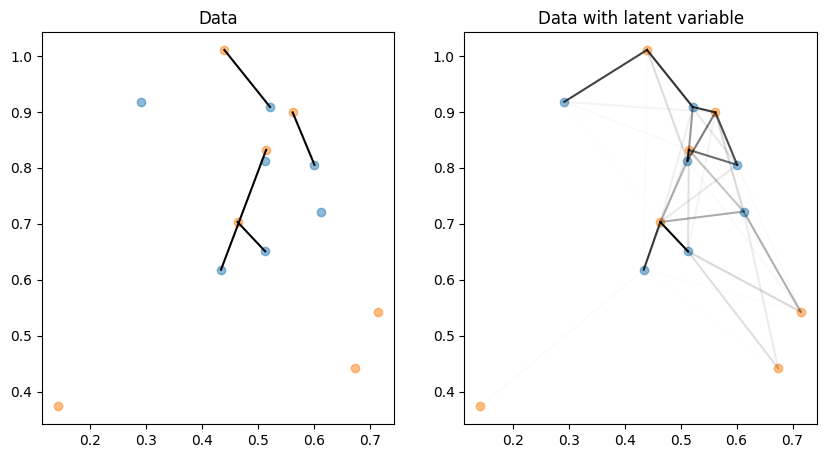

In [11]:
fig, axis = plt.subplots(ncols=2, figsize=(10, 15))
for ax in axis:
    ax.scatter(x[:, 0], x[:, 1], alpha=0.5)
    ax.scatter(y[:, 0], y[:, 1], color="tab:orange", alpha=0.5)
    ax.set_aspect("equal")
plot_2d_plan(x, y, matching_mat, ax=axis[0])
# plot_2d_plan(x, y, chain.EZ(), ax=axis[1])
plot_2d_plan(x, y, chain.pairing_probabilities(), ax=axis[1])
axis[0].set_title("Data")
axis[1].set_title("Data with latent variable")
plt.show()

In [12]:

ns, pair_post_exact = pair_abundance_posterior(gamma_mat, mu_vec, nu_vec)

print(pair_post_exact)

[4.38422697e-04 1.27162091e-02 1.13648463e-01 3.66454917e-01
 3.87138301e-01 1.14671857e-01 4.93035998e-03 1.46978157e-06]


[4.38422697e-04 1.27162091e-02 1.13648463e-01 3.66454917e-01
 3.87138301e-01 1.14671857e-01 4.93035998e-03 1.46978157e-06]
[3.33222259e-04 6.33122293e-03 1.22625791e-01 4.25524825e-01
 3.53215595e-01 9.19693436e-02 0.00000000e+00 0.00000000e+00]


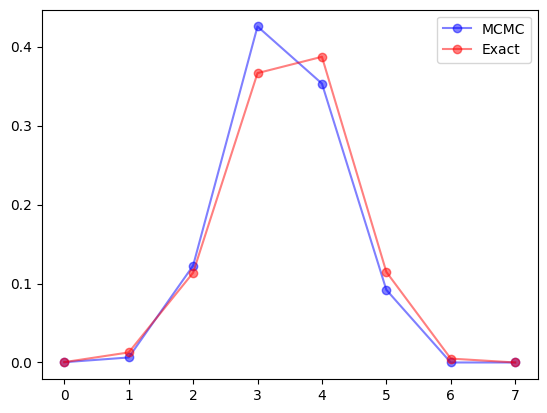

In [13]:
nx = len(x)
ny = len(y)
n_max = min(nx, ny)
n_max = np.minimum(nx, ny)

bins = np.arange(n_max+2)-0.5
hist = np.histogram(chain.pair_count_trajectory, bins=bins)[0]
hist = hist/np.sum(hist)
print(pair_post_exact/np.sum(pair_post_exact))
print(hist)


hist = np.histogram(chain.pair_count_trajectory, bins=bins)[0]
plt.plot(np.arange(n_max+1), hist/np.sum(hist), alpha=0.5, label="MCMC", color="blue", marker="o")
plt.plot(np.arange(n_max+1), pair_post_exact/np.sum(pair_post_exact), alpha=0.5, label="Exact", color="red", marker="o")
# plt.step(np.arange(n_max+2)-0.5, pair_post_exact/np.sum(pair_post_exact), alpha=0.5, label="Exact")
plt.legend()
# plt.vlines(x=n_gamma, ymin=0, ymax=1, color="red")
plt.show()

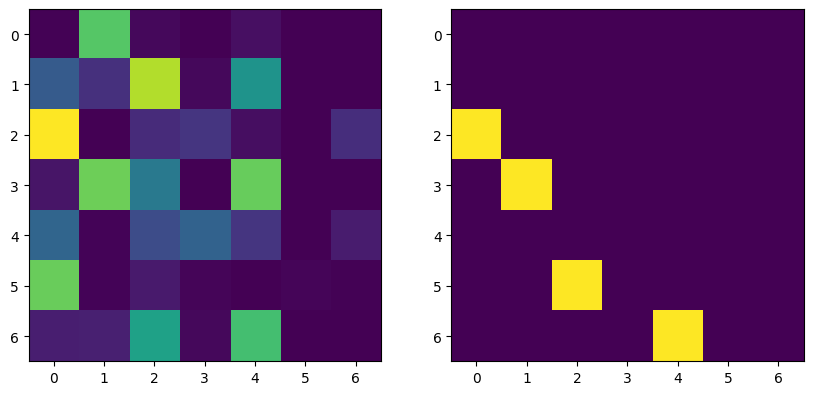

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(chain.pairing_probabilities())
ax[1].imshow(matching_mat)

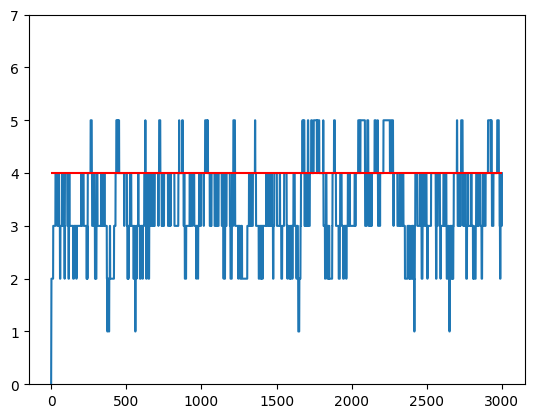

In [15]:
plt.plot(chain.pair_count_trajectory)
plt.ylim((0, np.minimum(len(x), len(y))))
plt.hlines(y=n_gamma, xmin=0, xmax=len(chain.pair_count_trajectory), color="red")
plt.show()